# Coding Assignment "Bonus #1"

__Goal:__ Make accurate predictions on the validation nodes.
<br>
__Task description:__ Ten weather stations have been randomly chosen as validation nodes (see plot in Section 2.3). Therefore, they __do not participate in the training__. You can imagine, that they lost their temperature measurements (labels). You must estimate the models' parameters of the validation nodes using any method(s) covered by Lecture Notes (see link below) and calculate the MSE for each validation node. Finally, calculate the average of all MSEs of the validation nodes.
<br>
__Important:__ do not modify the sections 1.2, 2.1, 2.2, and 2.3!
<br>
__Grading:__ the submissions will be rated based on the achieved average error over validation nodes. The submission with the minimum error will be graded with 11 points, the second best result will be graded with 10 points, ... the fifth best result will be graded with 7 points. All other submissions will be graded with 6 points (if the achieved average error is __less than 30__) or 0 points (if the achieved average error is __greater than or equal to 30__). 
<br>
__Hints:__
* Section 1.2 contains the _val_nodes_avg_error()_ function that calculates the average of MSEs of the validation nodes. 
* Try to construct relevant edges between similar nodes.
* Try to work with clustered data set.
* Usefull algorithms: FedGD, FedAvg, KMeans. 
* Try out different hyperparameters.
* You can copy code from previous assignments including the reference solutions.

Lecture Notes: https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FL_LectureNotes.pdf

## 1. Preparation

### 1.1. Libraries

In [2]:
# Modules.
import colorsys
import numpy as np 
import pandas as pd 
import networkx as nx 

# Submodules
from numpy import linalg as LA
import matplotlib.pyplot as plt 

# Methods
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### 1.2. Helper functions

In [3]:
# The function generates returns the numpy array
# of num_colors distinctive colors in RGB format.
def generate_distinctive_colors(num_colors):
    colors = []
    hue_step = 1.0 / num_colors
    saturation = 0.7
    value = 0.9
    for i in range(num_colors):
        hue = i * hue_step
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return np.array(colors)

# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI, highlight_val_nodes=True):
    # Get the number of clusters.
    num_clusters = len(set([G_FMI.nodes[node]['cluster'] for node in G_FMI.nodes]))
    
    # Get the colors for clusters (+1 for validation nodes).
    colors = generate_distinctive_colors(num_clusters + 1)
    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['validation'] and highlight_val_nodes:
            color = colors[-1]
            plt.scatter(coords[node,1], coords[node,0], color=color, s=4, zorder=5)  # zorder ensures nodes are on top of edges
            plt.text(coords[node,1]+0.1, coords[node,0]+0.2, f"Validation ({node})", fontsize=8, ha='center', va='center', color=color, fontweight='bold')
        else:
            color = colors[G_FMI.nodes[node]['cluster']]
            plt.scatter(coords[node,1], coords[node,0], color=color, s=4, zorder=5)  # zorder ensures nodes are on top of edges
            plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color=color, fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    n_features = 7 
    n_datapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of a data point) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((n_datapoints, n_features))
    y = np.zeros((n_datapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label. 
    for i in range(n_datapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[i])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[i])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[i]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[i], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[i,:] = [lat, lon, year, month, day, hour, minute]
        y[i,:] = tmp

    return X, y

def choose_val_nodes(graph_FMI, n_nodes, seed=4740):
    np.random.seed(seed)
    
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Choose validation nodes.
    val_nodes = np.random.choice(graph.nodes, size=n_nodes)
    for val_node in val_nodes:
        graph.nodes[val_node]['validation'] = True
    
    return graph

def get_train_val_nodes(graph_FMI):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Create storages.
    train_nodes = []
    val_nodes = []
    
    # Distribute the nodes.
    for node in graph.nodes:
        if graph.nodes[node]['validation']:
            val_nodes.append(node)
        else:
            train_nodes.append(node)
        
    # Make numpy arrays.
    train_nodes = np.array(train_nodes)
    val_nodes = np.array(val_nodes)
    
    return train_nodes, val_nodes

def val_nodes_avg_error(graph_FMI):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Get validation nodes.
    _, val_nodes = get_train_val_nodes(graph)
    
    # Create storage for the validation errors.
    val_errors = np.zeros(len(val_nodes))
    
    for i, val_node in enumerate(val_nodes):
        # Calculate the errors of validation nodes
        X_val_node = graph.nodes[val_node]['X']
        y_val_node = graph.nodes[val_node]['y']
        w_val_node = graph.nodes[val_node]['weights']
        val_errors[i] = mean_squared_error(y_val_node, X_val_node.dot(w_val_node))
        
    return np.mean(val_errors)

## 2. Data

### 2.1. Dataset

In [4]:
# Import the weather measurements.
data_FMI = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
n_stations = len(data_FMI.name.unique())
n_datapoints = len(data_FMI)

### 2.2. Features and labels

In [5]:
# Extract features and labels from the FMI data.
X, y = ExtractFeatureMatrixLabelVector(data_FMI)

print(f"The created feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The created label vector contains {np.shape(y)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


### 2.3. Empirical graph

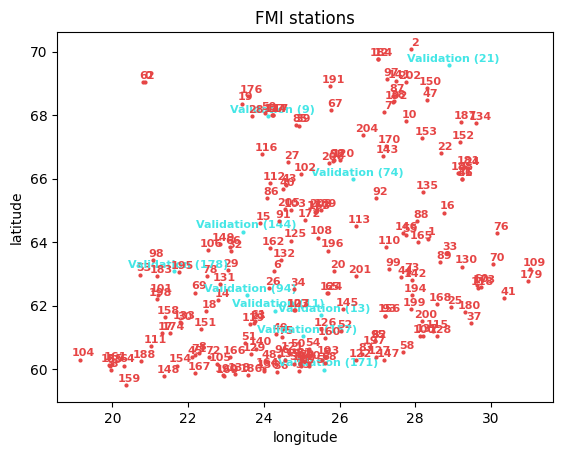

In [8]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data_FMI.name.unique()):
    # Extract data of a certain station
    station_data = data_FMI[data_FMI.name==station]
    
    # Extract features and labels of a certain station.
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    # Store the station's data in the node's attributes. 
    G_FMI.nodes[i]['samplesize'] = len(y_node) # The number of measurements of the i-th weather station.
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station.
    G_FMI.nodes[i]['coord'] = np.array([station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]]) # The coordinates of the i-th weather station.
    G_FMI.nodes[i]['X'] = X_node # The feature matrix for local dataset at node i.
    G_FMI.nodes[i]['y'] = y_node  # The  label vector for local dataset at node i.
    G_FMI.nodes[i]['z'] = None # The representation vector for local dataset at node i.
    G_FMI.nodes[i]['weights'] = np.zeros((X_node.shape[1], 1)) # The weight vector of the local model at node i.
    G_FMI.nodes[i]['cluster'] = 0 # The cluster to which the node is assigned (default value = 0).
    G_FMI.nodes[i]['validation'] = False # If the node is validation or not.

# Choose validation nodes.
G_FMI = choose_val_nodes(G_FMI, 10, seed=4740)

# Visualize the empirical graph.
plotFMI(G_FMI, highlight_val_nodes=True)

## 3. Student task

In [51]:
####################TODO####################
# TODO: Make accurate predictions on the validation nodes.
#
# NOTE: See task description before Section 1.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from collections import OrderedDict


class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(7, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
def val_nodes_avg_error(graph_FMI, model):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Get validation nodes.
    _, val_nodes = get_train_val_nodes(graph)
    
    # Create storage for the validation errors.
    val_errors = np.zeros(len(val_nodes))
    
    for i, val_node in enumerate(val_nodes):
        # Calculate the errors of validation nodes
        X_val_node = graph.nodes[val_node]['X']
        y_val_node = graph.nodes[val_node]['y']
        w_val_node = graph.nodes[val_node]['weights']
        with torch.no_grad():
            val_errors[i] = mean_squared_error(y_val_node, model(torch.tensor(X_val_node, dtype=torch.float32)).flatten().numpy())
        
    return np.mean(val_errors)

# Initialize the model in each node
train_nodes, val_nodes = get_train_val_nodes(G_FMI)

# Define hyperparameters
alpha = 0.5
l_rate = 0.001

# Define initial values and storage
prev_loss_avg = 1e10
curr_loss_avg = 1e9
tol = 0.01
n_iterations = 0

global_model = NeuralNetwork()
for node in train_nodes:
    G_FMI.nodes[node]['model'] = deepcopy(global_model)
    G_FMI.nodes[node]['optimizer'] = optim.SGD(G_FMI.nodes[node]['model'].parameters(), lr=0.001)


total_data = sum(map(lambda item: G_FMI.nodes[item]["samplesize"], train_nodes))

# Iterate while the average loss over all nodes is decreasing
while curr_loss_avg < prev_loss_avg:
    
    n_iterations += 1
    losses = np.zeros(n_stations)

    
    # Iterate over all nodes
    for current_node in train_nodes:
        model = G_FMI.nodes[current_node]['model']
        optimizer = G_FMI.nodes[current_node]['optimizer']
        
        # Get training data.
        X_train = torch.tensor(G_FMI.nodes[current_node]['X'], dtype=torch.float32)
        y_train = torch.tensor(G_FMI.nodes[current_node]['y'], dtype=torch.float32)

        # Forward pass
        outputs = model(X_train)
        loss = torch.nn.functional.mse_loss(outputs, y_train)
        losses[current_node] = loss.item()
        
        # Compute the gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    global_state_dict = OrderedDict()
    
    for node in train_nodes:
        model_node = G_FMI.nodes[node]["model"]
        node_size = G_FMI.nodes[node]["samplesize"]
        model_node_state_dict = model_node.state_dict()

        for name in model_node_state_dict:
            if name in global_state_dict:
                global_state_dict[name] += node_size / total_data * model_node_state_dict[name]
            else:
                global_state_dict[name] = node_size / total_data * model_node_state_dict[name]
        
    global_model.load_state_dict(global_state_dict)
    
    for node in train_nodes:
        G_FMI.nodes[node]["model"].load_state_dict(global_state_dict)
        
    prev_loss_avg = curr_loss_avg
    curr_loss_avg = np.mean(losses)
    val_loss = val_nodes_avg_error(G_FMI, model)
    print(f"Iteration: {n_iterations}, average loss: {curr_loss_avg}, val loss: {val_loss}")
    
print(f"{n_iterations} iterations have been performed. The average loss is {prev_loss_avg}")

Iteration: 1, average loss: 163.7382470121706, val loss: 153.5957746547707
Iteration: 2, average loss: 155.74281460536275, val loss: 145.60944445095012
Iteration: 3, average loss: 147.9973622865723, val loss: 137.29590251911242
Iteration: 4, average loss: 139.92728352892226, val loss: 128.29180487541217
Iteration: 5, average loss: 131.17748594053703, val loss: 118.46586311284143
Iteration: 6, average loss: 121.6147593760836, val loss: 107.9115688748416
Iteration: 7, average loss: 111.3238155392633, val loss: 97.02013091839233
Iteration: 8, average loss: 100.67655384598147, val loss: 86.38154066144774
Iteration: 9, average loss: 90.23929533290402, val loss: 76.69428314142081
Iteration: 10, average loss: 80.68645179674822, val loss: 68.56640727323565
Iteration: 11, average loss: 72.61290089980416, val loss: 62.34304168058725
Iteration: 12, average loss: 66.36566790060145, val loss: 58.01283850038917
Iteration: 13, average loss: 61.951431366556506, val loss: 55.266063446061786
Iteration: 

In [52]:
def val_nodes_avg_error(graph_FMI, model):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Get validation nodes.
    _, val_nodes = get_train_val_nodes(graph)
    
    # Create storage for the validation errors.
    val_errors = np.zeros(len(val_nodes))
    
    for i, val_node in enumerate(val_nodes):
        # Calculate the errors of validation nodes
        X_val_node = graph.nodes[val_node]['X']
        y_val_node = graph.nodes[val_node]['y']
        w_val_node = graph.nodes[val_node]['weights']
        with torch.no_grad():
            val_errors[i] = mean_squared_error(y_val_node, model(torch.tensor(X_val_node, dtype=torch.float32)).flatten().numpy())
        
    return np.mean(val_errors)

val_nodes_avg_error(G_FMI, global_model)

28.68337080293947